In [2]:
# replace path with the folder that contains the 'mlruns' directory
!mlflow ui --backend-store-uri file:../outputs/mlflow_artifacts/mlruns --port 5000


[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allowed-origins.
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)
INFO:     Started parent process [62162]
INFO:     Started server process [62164]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Started server process [62166]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Started server process [62167]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Started server process [62165]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:55636 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=5&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:55636 - "GET /static-files/static/css/478

Experiments found:
  id=810004900263659245 name='llm-neo-sst2'
  id=0 name='Default'
Using experiment id: 810004900263659245 (name=llm-neo-sst2)
Found 1 runs (showing up to 50). Run IDs:
  2c34b9f16026449eaea9ffc1b417d868 | status: FINISHED | start: 1764416933247 | params: {'num_beams': '1', 'early_stopping': 'False', 'hidden_size': '2048', 'use_legacy_prediction_loop': 'False', 'output_scores': 'False', 'num_attention_heads': '32', 'label_smoothing_factor': '0.0', 'save_strategy': 'steps', 'average_tokens_across_devices': 'True', 'attention_dropout': '0.0', 'head_dim': '64', 'deepspeed': 'None', 'half_precision_backend': 'auto', 'restore_callback_states_from_checkpoint': 'False', 'temperature_start': '2.0', 'max_position_embeddings': '131072', 'neftune_noise_alpha': 'None', 'parallelism_config': 'None', 'tie_word_embeddings': 'True', 'adafactor': 'False', '_name_or_path': 'NousResearch/Llama-3.2-1B', 'hub_always_push': 'False', 'per_gpu_eval_batch_size': 'None', 'ddp_broadcast_buffers

/var/folders/hm/xl10r_9x1rb9sblp609s0jkr0000gn/T/ipykernel_61947/2739368571.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = hist_df["step"].fillna(method="ffill")
/var/folders/hm/xl10r_9x1rb9sblp609s0jkr0000gn/T/ipykernel_61947/2739368571.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = hist_df["step"].fillna(method="ffill")
/var/folders/hm/xl10r_9x1rb9sblp609s0jkr0000gn/T/ipykernel_61947/2739368571.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = hist_df["step"].fillna(method="ffill")
/var/folders/hm/xl10r_9x1rb9sblp609s0jkr0000gn/T/ipykernel_61947/2739368571.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
 

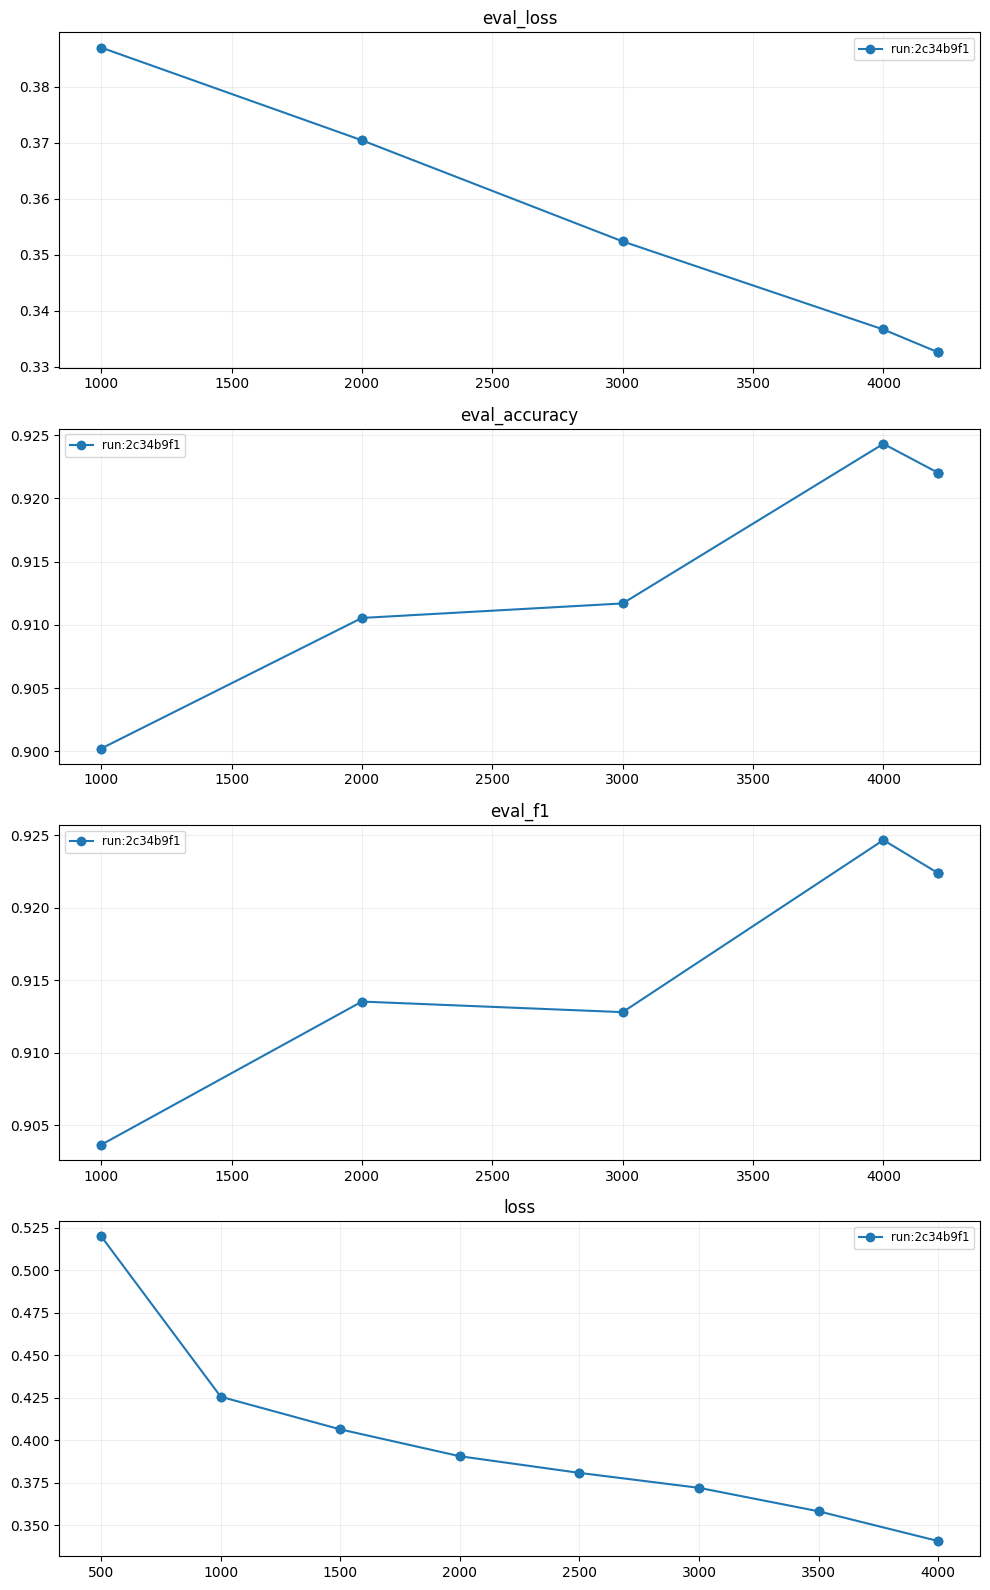

In [ ]:

import os
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

MLRUNS_PATH = "../outputs/mlflow_artifacts/mlruns"   
MLFLOW_URI = f"file:{MLRUNS_PATH}"

# init client
client = MlflowClient(tracking_uri=MLFLOW_URI)

# list experiments
exps = client.search_experiments()
print("Experiments found:")
for e in exps:
    print(f"  id={e.experiment_id} name='{e.name}'")

# choose experiment (by name or id)
EXP_NAME = "llm-neo-sst2"   
exp = client.get_experiment_by_name(EXP_NAME)
if exp is None:
    raise ValueError(f"Experiment '{EXP_NAME}' not found in {MLRUNS_PATH}. Available: {[e.name for e in exps]}")
exp_id = exp.experiment_id
print(f"Using experiment id: {exp_id} (name={exp.name})")


def metric_history(run_id, metric_key):
    hist = client.get_metric_history(run_id, metric_key)

    entries = [(m.step if hasattr(m, "step") else getattr(m, "step", None),
                m.value,
                m.timestamp) for m in hist]

    entries = sorted(entries, key=lambda x: (x[0] if x[0] is not None else 0, x[2]))
    df = pd.DataFrame(entries, columns=["step","value","timestamp"])
    return df


runs = client.search_runs(exp_id, order_by=["attributes.start_time DESC"], max_results=50)
print(f"Found {len(runs)} runs (showing up to 50). Run IDs:")
for r in runs:
    print(" ", r.info.run_id, "| status:", r.info.status, "| start:", r.info.start_time, "| params:", r.data.params)


metric_keys = ["eval_loss", "eval_accuracy", "eval_f1", "loss"]


plt.figure(figsize=(10,4*len(metric_keys)))
for i, key in enumerate(metric_keys):
    plt.subplot(len(metric_keys), 1, i+1)
    plotted = False
    for r in runs:
        run_id = r.info.run_id
        hist_df = metric_history(run_id, key)
        if hist_df is None or hist_df.empty:
            continue
        plotted = True

        x = hist_df["step"].fillna(method="ffill")
        if x.isna().all():
            x = pd.to_datetime(hist_df["timestamp"], unit='ms')
        y = hist_df["value"].astype(float)
        plt.plot(x, y, marker="o", label=f"run:{run_id[:8]}")
    if plotted:
        plt.title(key)
        plt.grid(alpha=0.2)
        plt.legend(fontsize="small", ncol=2)
    else:
        plt.title(f"{key} (no history found)")
plt.tight_layout()
plt.show()
